# Importar bibliotecas

In [28]:
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)# Removendo notações científicas

import requests, json
from Conexão_Banco_de_Dados_Oracle import conectar_bd
from pycep_correios import get_address_from_cep, WebService

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(suppress=False) # Removendo notações científicas
from datetime import datetime
from tqdm import tqdm # Barprogress
import os

# Remover warnings dos kernels
import warnings
warnings.filterwarnings('ignore')

# Conectar ao banco de dados (cursor)

In [29]:
conn = conectar_bd()
cursor = conn.cursor()

# Extração de dados

In [30]:
# Função de extração de dados do CNPJ
def _dados_cnpj(cnpj):
    return json.loads(requests.get(f'https://thecollector.linkana.com/companies?cnpj=eq.{cnpj}&limit=1%27').text)[0]

# Buscando informações de geolocalização
def busca_geolocation(cep):
    try:
        # Ajustar para parametro de pesquisa URL
        '''
        Obs: Foi acrescentado o replace para Bonfim Paulista pois era uma exceção que estava ocasionando erros "desenecessários"
        '''
        r = lambda x: x.replace('Bonfim Paulista (Ribeirão Preto)', 'Ribeirão Preto').replace(' ', '+')

        URL = "https://nominatim.openstreetmap.org/search?format=json&addressdetails=1&country=$brazil&state=${}&city=${}&limit=1"
        infos = get_address_from_cep(cep, webservice=WebService.CORREIOS)
        dados_cep = json.loads(requests.get(URL.format(infos['uf'], r(infos['cidade']))).text)[0]

        return (dados_cep['lat'], dados_cep['lon'], dados_cep['importance'], dados_cep['address']['state_district'])
    except:
        return (np.nan, np.nan, np.nan, np.nan)

In [31]:
# Teste função de geolocalização
busca_geolocation('44025930')

(nan, nan, nan, nan)

In [32]:
def obter_dados():
    # Dados cadastrais
    cons_empresas_cadastradas = '''
    SELECT 
        a.CODEMPRESA, a.RAZAOSOCIAL, a.NOMEFANTASIA, 
        d.CEP, d.NUMCNPJCPF
    FROM HINOERP_BIO.GEEMPRESA a
        LEFT JOIN HINOERP_BIO.GEEMPRESAPARAMESTAB b
            ON a.CODEMPRESA = b.CODEMPRESA
        LEFT JOIN HINOERP_BIO.GEENDEMPRESA c
            ON a.CODEMPRESA = c.CODEMPRESA
        LEFT JOIN HINOERP_BIO.GEENDERECO d
            ON c.CODENDERECO = d.CODENDERECO
        WHERE TIPOEMPRESA = 'C' AND LENGTH(d.NUMCNPJCPF) = 14
    '''
    df_empresas_cadastradas = pd.read_sql(cons_empresas_cadastradas, conn)

    # Retornando data de cadastro das empresas
    cons = '''
    SELECT e.DATALOG as DATACADASTRO, PARA AS CODEMPRESA
    FROM HINOERP_BIO.GELOG E
    LEFT JOIN HINOERP_BIO.GELOGDET b
    ON E.CODLOG = b.CODLOG
    WHERE TABELA = 'GEEMPRESA' AND CAMPO = 'Cód. Empresa' AND DE IS NULL
    '''
    datas_cadastros = pd.read_sql(cons, conn)
    datas_cadastros['CODEMPRESA'] = datas_cadastros['CODEMPRESA'].astype(int)

    # Merge das informações
    df_empresas_cadastradas = df_empresas_cadastradas.merge(datas_cadastros, on='CODEMPRESA', how='left')

    # Dados financeiros
    cons_dados_financeiros = '''
    SELECT 
        e.CODEMPRESA, 
        SUM(e.VALORORIGINAL) AS TOTALVENDAS, 
        AVG(e.VALORJUROS) AS MEDIAJUROS, 
        AVG(e.DATALIQUIDACAO - e.DATAVENCIMENTO) AS DIASATRASO
    FROM HINOERP_BIO.FITITULOS e
    WHERE e.INDICENFSAIDA IS NOT NULL
    GROUP BY CODEMPRESA
    '''

    df_titulos = pd.read_sql(cons_dados_financeiros, conn)

    # Unindo as informações
    df = df_empresas_cadastradas.merge(df_titulos, on='CODEMPRESA', how='left').fillna(0)
    df.index = [i for i in range(df.shape[0])]

    # Criação de um dicionário auxiliar
    dict_aux = {
        'Data Abertura CNPJ': [],
        'Capital Social': [],
        'Natureza Jurídica': [],
        'Porte': [],
        "CNAE's": [],
        "Latitude": [],
        "Longitude": [],
        "NvlImportanciaGEO": [],
        "Região": []
    }

    # Alimentando o dicionário auxiliar
    for i in tqdm(range(df.shape[0])):
        dados_consulta_cnpj = _dados_cnpj(df['NUMCNPJCPF'][i])
        lat, lon, importance, regiao = busca_geolocation(dados_consulta_cnpj['cep'])

        # Dados geolocalização
        dict_aux['Latitude'].append(lat)
        dict_aux['Longitude'].append(lon)
        dict_aux['NvlImportanciaGEO'].append(importance)
        dict_aux['Região'].append(regiao)

        # Dados CNPJ
        dict_aux['Data Abertura CNPJ'].append(dados_consulta_cnpj['data_inicio_atividade'])
        dict_aux['Capital Social'].append(str(dados_consulta_cnpj['capital_social'])[:-2])
        dict_aux['Natureza Jurídica'].append(dados_consulta_cnpj['natureza_juridica'])
        dict_aux['Porte'].append(dados_consulta_cnpj['cod_porte_empresa'])
        cnaes = [dados_consulta_cnpj['cnae_fiscal']]
        if dados_consulta_cnpj['cnaes_secundarios'] != None:
            cnaes = cnaes + dados_consulta_cnpj['cnaes_secundarios']
        dict_aux["CNAE's"].append(cnaes)

    # Transformando o DF auxiliar em objeto Pandas e concatenando com o DF de infos baixadas
    df_aux = pd.DataFrame.from_dict(dict_aux)
    df = pd.concat([df, df_aux], axis=1)
    
    # Salvando o arquivo
    df.to_csv(arquivo, sep=';', encoding='ISO-8859-1', index=False)
    
# Check se existe o arquivo
arquivo = 'base_dados.csv'
if not (arquivo in os.listdir()):
    obter_dados()

df = pd.read_csv(arquivo, sep=';', encoding='ISO-8859-1')

#Removendo colunas de identificação dos clientes
df = df.drop(['RAZAOSOCIAL', 'NOMEFANTASIA', 'NUMCNPJCPF'], axis=1)
print('Dataframe lido com sucesso !')

Dataframe lido com sucesso !


# EDA - Análise Exploratória de Dados

- <b> Conhecendo nossos dados.

In [33]:
df.head()

,CODEMPRESA,CEP,DATACADASTRO,TOTALVENDAS,MEDIAJUROS,DIASATRASO,Data Abertura CNPJ,Capital Social,Natureza Jurídica,Porte,CNAE's,Latitude,Longitude,NvlImportanciaGEO,Região
0,364,17016160,2021-01-06 20:04:00,0.000,0.000,-6.000,1997-01-28T00:00:00,200000.000,Sociedade Empresária Limitada,5,"['4645102', '4664800']",-22.322,-49.071,0.652,Região Geográfica Intermediária de Bauru
1,366,30150010,2021-01-07 18:55:02,0.000,0.000,0.000,2014-10-06T00:00:00,110000.000,Empresa Individual de Responsabilidade Limitad...,3,"['4773300', '7729203', '7739002']",-19.923,-43.945,0.825,Região Geográfica Intermediária de Belo Horizonte
2,367,4038002,2021-01-07 19:03:19,0.000,0.000,0.000,2005-08-01T00:00:00,320000.000,Sociedade Empresária Limitada,5,"['4645101', '4645102', '4618402']",-23.551,-46.633,0.886,Região Geográfica Intermediária de São Paulo
3,368,22775022,2021-01-07 19:47:13,52390.030,12.049,6.893,2010-11-05T00:00:00,20000.000,Sociedade Empresária Limitada,1,"['4645101', '3312103', '4619200', '4645102', '...",-22.911,-43.209,1.015,Região Geográfica Intermediária do Rio de Janeiro
4,369,1424906,2021-01-08 10:44:39,187989.810,0.134,0.469,1993-06-29T00:00:00,3000000.000,Sociedade Empresária Limitada,5,"['4645101', '4645102', '4646001']",-23.551,-46.633,0.886,Região Geográfica Intermediária de São Paulo


In [34]:
print(df.shape)
df.isnull().sum()

(451, 15)


CODEMPRESA            0
CEP                   0
DATACADASTRO          0
TOTALVENDAS           0
MEDIAJUROS            0
DIASATRASO            0
Data Abertura CNPJ    0
Capital Social        3
Natureza Jurídica     0
Porte                 0
CNAE's                0
Latitude              7
Longitude             7
NvlImportanciaGEO     7
Região                7
dtype: int64

Resolvi por excluir as amostras com dados missing pelos seguintes motivos:
- poucos dados missing;
- os dados realmente não estavam disponíveis no sistema de coleta de dados 

In [35]:
df = df.dropna()
df.shape

(442, 15)

- <strong>Cardinalidade das variáveis<br><strong>
    
Esta métrica nos ajuda a entender quão dispostos os valores estão em um conjunto.<br>
Sendo assim, uma medida importante pois quanto maior a cardinalidade (maior número de valores únicos), menor será a probabilidade que o modelo consiga generalizar as predições.

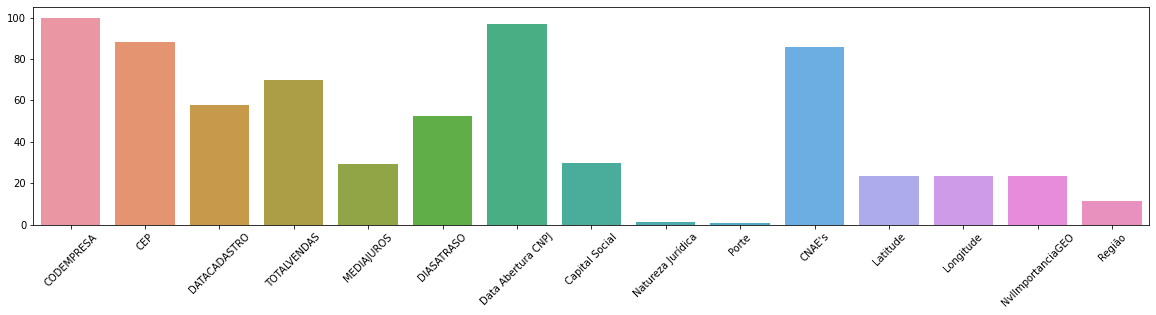

In [36]:
data = (df.nunique() / df.shape[0]) * 100
plt.figure(figsize=(20,4))
sns.barplot(x=data.index, y=data.values)
plt.xticks(rotation = 45)
plt.show()

Agora, iremos tratar as colunas com cardinalidade alta e moderada/alta

In [37]:
baixa_card = data[data <= 25].index
mod_baixa_card = data[(data > 25) & (data <= 50)].index
mod_alta_card = data[(data > 50) & (data <= 75)].index
alta_card = data[data > 75].index

### Features de cardinalidade moderada/alta

In [38]:
display(df[mod_alta_card].head(4))
df[mod_alta_card].dtypes

,DATACADASTRO,TOTALVENDAS,DIASATRASO
0,2021-01-06 20:04:00,0.000,-6.000
1,2021-01-07 18:55:02,0.000,0.000
2,2021-01-07 19:03:19,0.000,0.000
3,2021-01-07 19:47:13,52390.030,6.893


DATACADASTRO     object
TOTALVENDAS     float64
DIASATRASO      float64
dtype: object

- [DATACADASTRO] - Datetime (object)

In [39]:
df['DATACADASTRO'].value_counts()

0                      187
2022-03-29 14:49:06      1
2022-05-03 13:39:02      1
2022-05-23 11:09:30      1
2022-07-14 20:11:09      1
2022-09-05 22:02:32      1
2022-10-14 12:05:27      1
2022-10-25 11:52:36      1
2021-03-26 10:39:15      1
2021-03-26 19:20:07      1
2021-04-19 10:28:20      1
2021-05-07 11:39:18      1
2021-05-10 16:47:18      1
2021-05-13 10:47:16      1
2021-06-14 22:04:45      1
2021-07-06 17:55:37      1
2021-01-06 20:04:00      1
2021-07-30 10:43:38      1
2021-08-20 11:53:28      1
2021-09-16 13:05:08      1
2021-09-16 13:31:36      1
2021-10-15 11:03:05      1
2022-01-05 11:12:36      1
2022-02-24 18:27:56      1
2022-02-25 16:47:42      1
2022-04-28 20:37:49      1
2022-05-30 13:03:43      1
2022-06-24 12:24:44      1
2022-08-15 10:34:32      1
2022-08-25 19:29:27      1
2022-09-06 20:53:11      1
2021-07-22 18:22:59      1
2022-02-24 16:45:31      1
2022-10-10 13:19:27      1
2021-10-07 19:14:51      1
2021-03-16 11:19:50      1
2021-03-31 16:25:30      1
2

Existe um dado incorreto (0), que será substituido pela data coletada manualmente (ERP).<br>
Em seguida, irei substituir esta variávei por uma nova variável correspondente à quantos meses o cliente está cadastrado.

In [40]:
df['DATACADASTRO'] = df['DATACADASTRO'].replace('0', '2021-01-10 00:00:01')
df['DATACADASTRO'] = pd.to_datetime(df['DATACADASTRO'], format='%Y-%m-%d %H:%M:%S')
df['MesesAtividade'] = (datetime.today() - df['DATACADASTRO']).dt.days / 30
df = df .drop('DATACADASTRO', axis=1)

Ao tratar a variável de vendas apenas como um total, pode ser que acabemos classificando um cliente recente com bom volume de compras no mesmo nicho que um cliente com baixo volume de compras porém a muito mais tempo cadastrado, então, para não penalisar o primeiro, criarei mais uma feature que contará com a média do faturamento mensal desde o cadastro do mesmo. Exemplo:
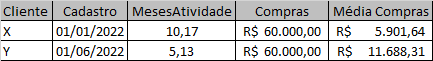

In [41]:
df['ComprasMes'] = df['TOTALVENDAS'] / df['MesesAtividade']
df = df.drop('TOTALVENDAS', axis=1)
mod_alta_card = ['ComprasMes', 'DIASATRASO', 'MesesAtividade']

In [42]:
df[mod_alta_card].describe()

,ComprasMes,DIASATRASO,MesesAtividade
count,442.000,442.000,442.000
mean,3432.410,0.296,17.474
std,7708.750,4.733,7.326
min,0.000,-64.000,0.267
25%,0.000,0.000,13.750
50%,904.833,0.000,22.033
75%,3517.468,0.582,22.033
max,96448.436,37.182,26.433


- [ComprasMes] - Float

[]

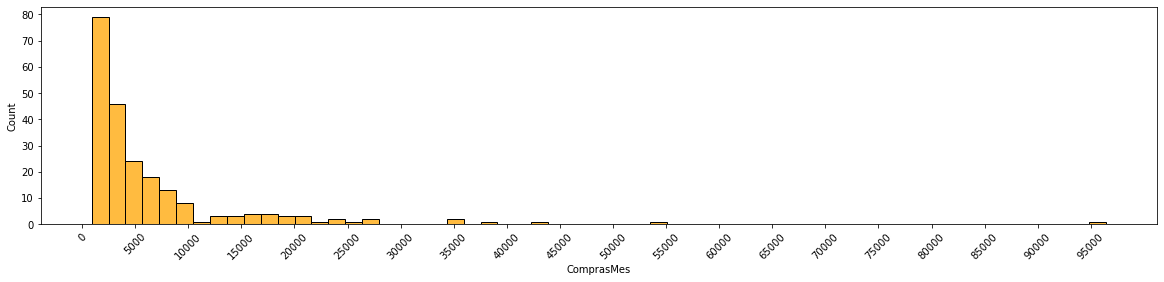

In [43]:
plt.figure(figsize=(20,4))
sns.histplot(df['ComprasMes'][df['ComprasMes'] > df['ComprasMes'].median()], color='orange')
plt.xticks(list(range(0,int(df['ComprasMes'].max()),5000)), rotation='45')
plt.plot()

Vamos dividir a variável (contínua) em classes:
- de 0 - 1000
- de 1000 - 2000
- de 2000 - 5000
- de 5000 - 10000
- de 10000 - 20000
- acima de 20000

In [44]:
df['ComprasMes'][(df['ComprasMes'] <= 1000)] = 0
df['ComprasMes'][(df['ComprasMes'] > 1000) & (df['ComprasMes'] <= 2000)] = 1
df['ComprasMes'][(df['ComprasMes'] > 2000) & (df['ComprasMes'] <= 5000)] = 2
df['ComprasMes'][(df['ComprasMes'] > 5000) & (df['ComprasMes'] <= 10000)] = 3
df['ComprasMes'][(df['ComprasMes'] > 10000) & (df['ComprasMes'] <= 20000)] = 4
df['ComprasMes'][(df['ComprasMes'] > 20000)] = 5

- [DIASATRASO] - Float

In [45]:
dias_atraso = pd.DataFrame.from_dict({'Dias': df['DIASATRASO'].value_counts().index, 
                                      'Qtde': df['DIASATRASO'].value_counts().values}).sort_values('Dias')
dias_atraso

,Dias,Qtde
42,-64.000,1
108,-22.658,1
119,-13.769,1
105,-9.857,1
28,-9.031,1
103,-7.400,1
228,-7.147,1
43,-6.000,1
150,-5.777,1
88,-5.750,1


Para esta variável, decidimos por classificar da seguinte forma:
- paga com antecedência: < que -1 dia
- paga em dia: > -1 dia < 3 dias (caso o titulo caia em fim de semana)
- paga com um pequeno atraso: > 3 dias < 6 dias
- paga com atraso recorrente: > 6 dias

In [46]:
df['DIASATRASO'][(df['DIASATRASO'] <= -1)] = 0
df['DIASATRASO'][(df['DIASATRASO'] > -1) & (df['DIASATRASO'] <= 3)] = 1
df['DIASATRASO'][(df['DIASATRASO'] > 3) & (df['DIASATRASO'] <= 6)] = 2
df['DIASATRASO'][(df['DIASATRASO'] > 6)] = 3

- [MesesAtividade] - Float

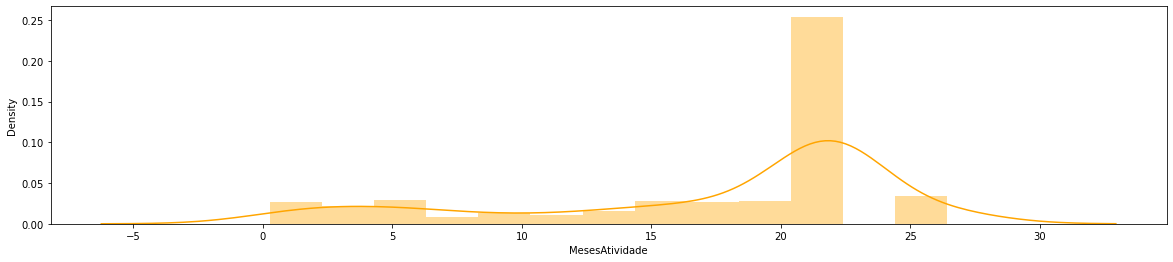

In [47]:
plt.figure(figsize=(20,4))
sns.distplot(df['MesesAtividade'], color='orange')
plt.show()

As amostras desta variável ficarão dispostas em classes de 6 em 6 meses.

In [48]:
m_inicial = 0
m_final = 6

for i in range(np.ceil(df['MesesAtividade'].max()/6).astype(int)):
    df['MesesAtividade'][(df['MesesAtividade'] > m_inicial) & (df['MesesAtividade'] <= m_final)] = i
    print(f'Faixa {i} - De {m_inicial} a {m_final} meses.')
    m_inicial += 6
    m_final += 6

Faixa 0 - De 0 a 6 meses.
Faixa 1 - De 6 a 12 meses.
Faixa 2 - De 12 a 18 meses.
Faixa 3 - De 18 a 24 meses.
Faixa 4 - De 24 a 30 meses.


### Features de cardinalidade alta

In [49]:
display(df[alta_card].head(4))
df[alta_card].dtypes

,CODEMPRESA,CEP,Data Abertura CNPJ,CNAE's
0,364,17016160,1997-01-28T00:00:00,"['4645102', '4664800']"
1,366,30150010,2014-10-06T00:00:00,"['4773300', '7729203', '7739002']"
2,367,4038002,2005-08-01T00:00:00,"['4645101', '4645102', '4618402']"
3,368,22775022,2010-11-05T00:00:00,"['4645101', '3312103', '4619200', '4645102', '..."


CODEMPRESA             int64
CEP                    int64
Data Abertura CNPJ    object
CNAE's                object
dtype: object

- [CODEMPRESA, CEP] - Int

Iremos remover estas colunas por apenas se tratarem de identificadores, sem nenhum valor para nosso modelo.

In [50]:
df = df.drop(['CODEMPRESA', 'CEP'], axis=1)

- [Data Abertura CNPJ] - Datetime (object)

Trataremos esta da mesma maneira que tratamos a feature de cadastro anteriormente porém, abordando em anos ao invés de meses.

In [51]:
df['Data Abertura CNPJ'] = pd.to_datetime(df['Data Abertura CNPJ'], format='%Y-%m-%d %H:%M:%S')
df['AnosExistencia'] = (datetime.today() - df['Data Abertura CNPJ']).dt.days / 365
df = df.drop('Data Abertura CNPJ', axis=1)

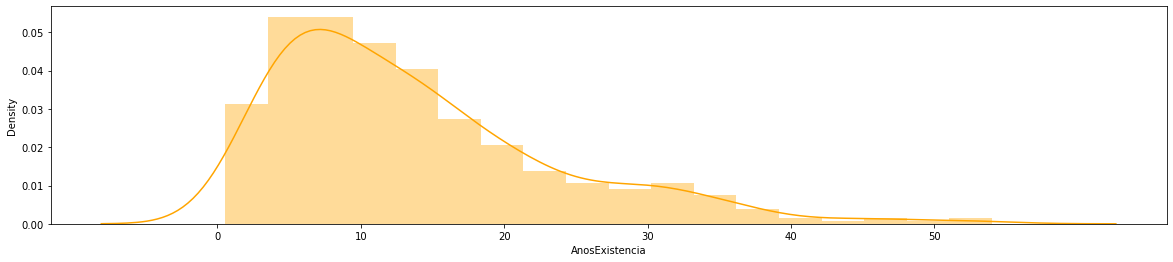

count   442.000
mean     13.644
std       9.743
min       0.542
25%       6.299
50%      11.303
75%      18.256
max      54.005
Name: AnosExistencia, dtype: float64

In [52]:
plt.figure(figsize=(20,4))
sns.distplot(df['AnosExistencia'], color='orange')
plt.xticks(list(range(0, int(df['AnosExistencia'].max()), 10)))
plt.show()
df['AnosExistencia'].describe()

Ao invés de classificar os dados em faixas, iremos de inicio tentar trabalhar com os dados transformando seus valores em inteiros. Caso necessite futuramente, deixarei esta variável salva.

In [53]:
df['AnosExistencia'] = df['AnosExistencia'].astype(int)

- [CNAE's] - List (object)

Como esta variável conta com uma lista de CNAE's (classificação de atividade economica), teremos que explodir estas listas para por fim criar uma nova coluna para cada um destes valores (encoding).

In [54]:
from ast import literal_eval
df["CNAE's"] = df["CNAE's"].apply(literal_eval) # Transforma em listas, algo como o astype

dummies_cnaes = pd.get_dummies(df["CNAE's"].explode())
dummies_cnaes = dummies_cnaes[~dummies_cnaes.index.duplicated(keep='first')]

df = df.drop("CNAE's", axis=1)
df = pd.concat([dummies_cnaes, df], axis=1)

In [60]:
cols_originais = df.columns[~df.columns.isin(dummies_cnaes)]
cols_originais

Index(['MEDIAJUROS', 'DIASATRASO', 'Capital Social', 'Natureza Jurídica',
       'Porte', 'Latitude', 'Longitude', 'NvlImportanciaGEO', 'Região',
       'MesesAtividade', 'ComprasMes', 'AnosExistencia'],
      dtype='object')

Cardinalidade Atual:


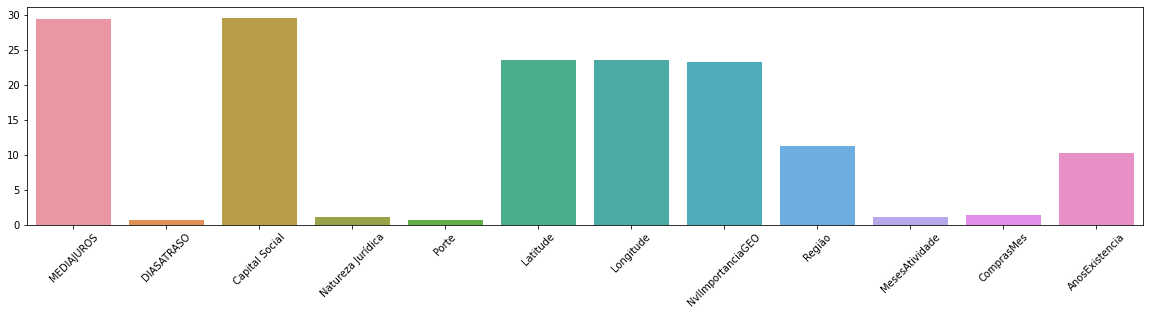

In [62]:
print('Cardinalidade Atual:')

data = (df[cols_originais].nunique() / df[cols_originais].shape[0]) * 100
plt.figure(figsize=(20,4))
sns.barplot(x=data.index, y=data.values)
plt.xticks(rotation = 45)
plt.show()

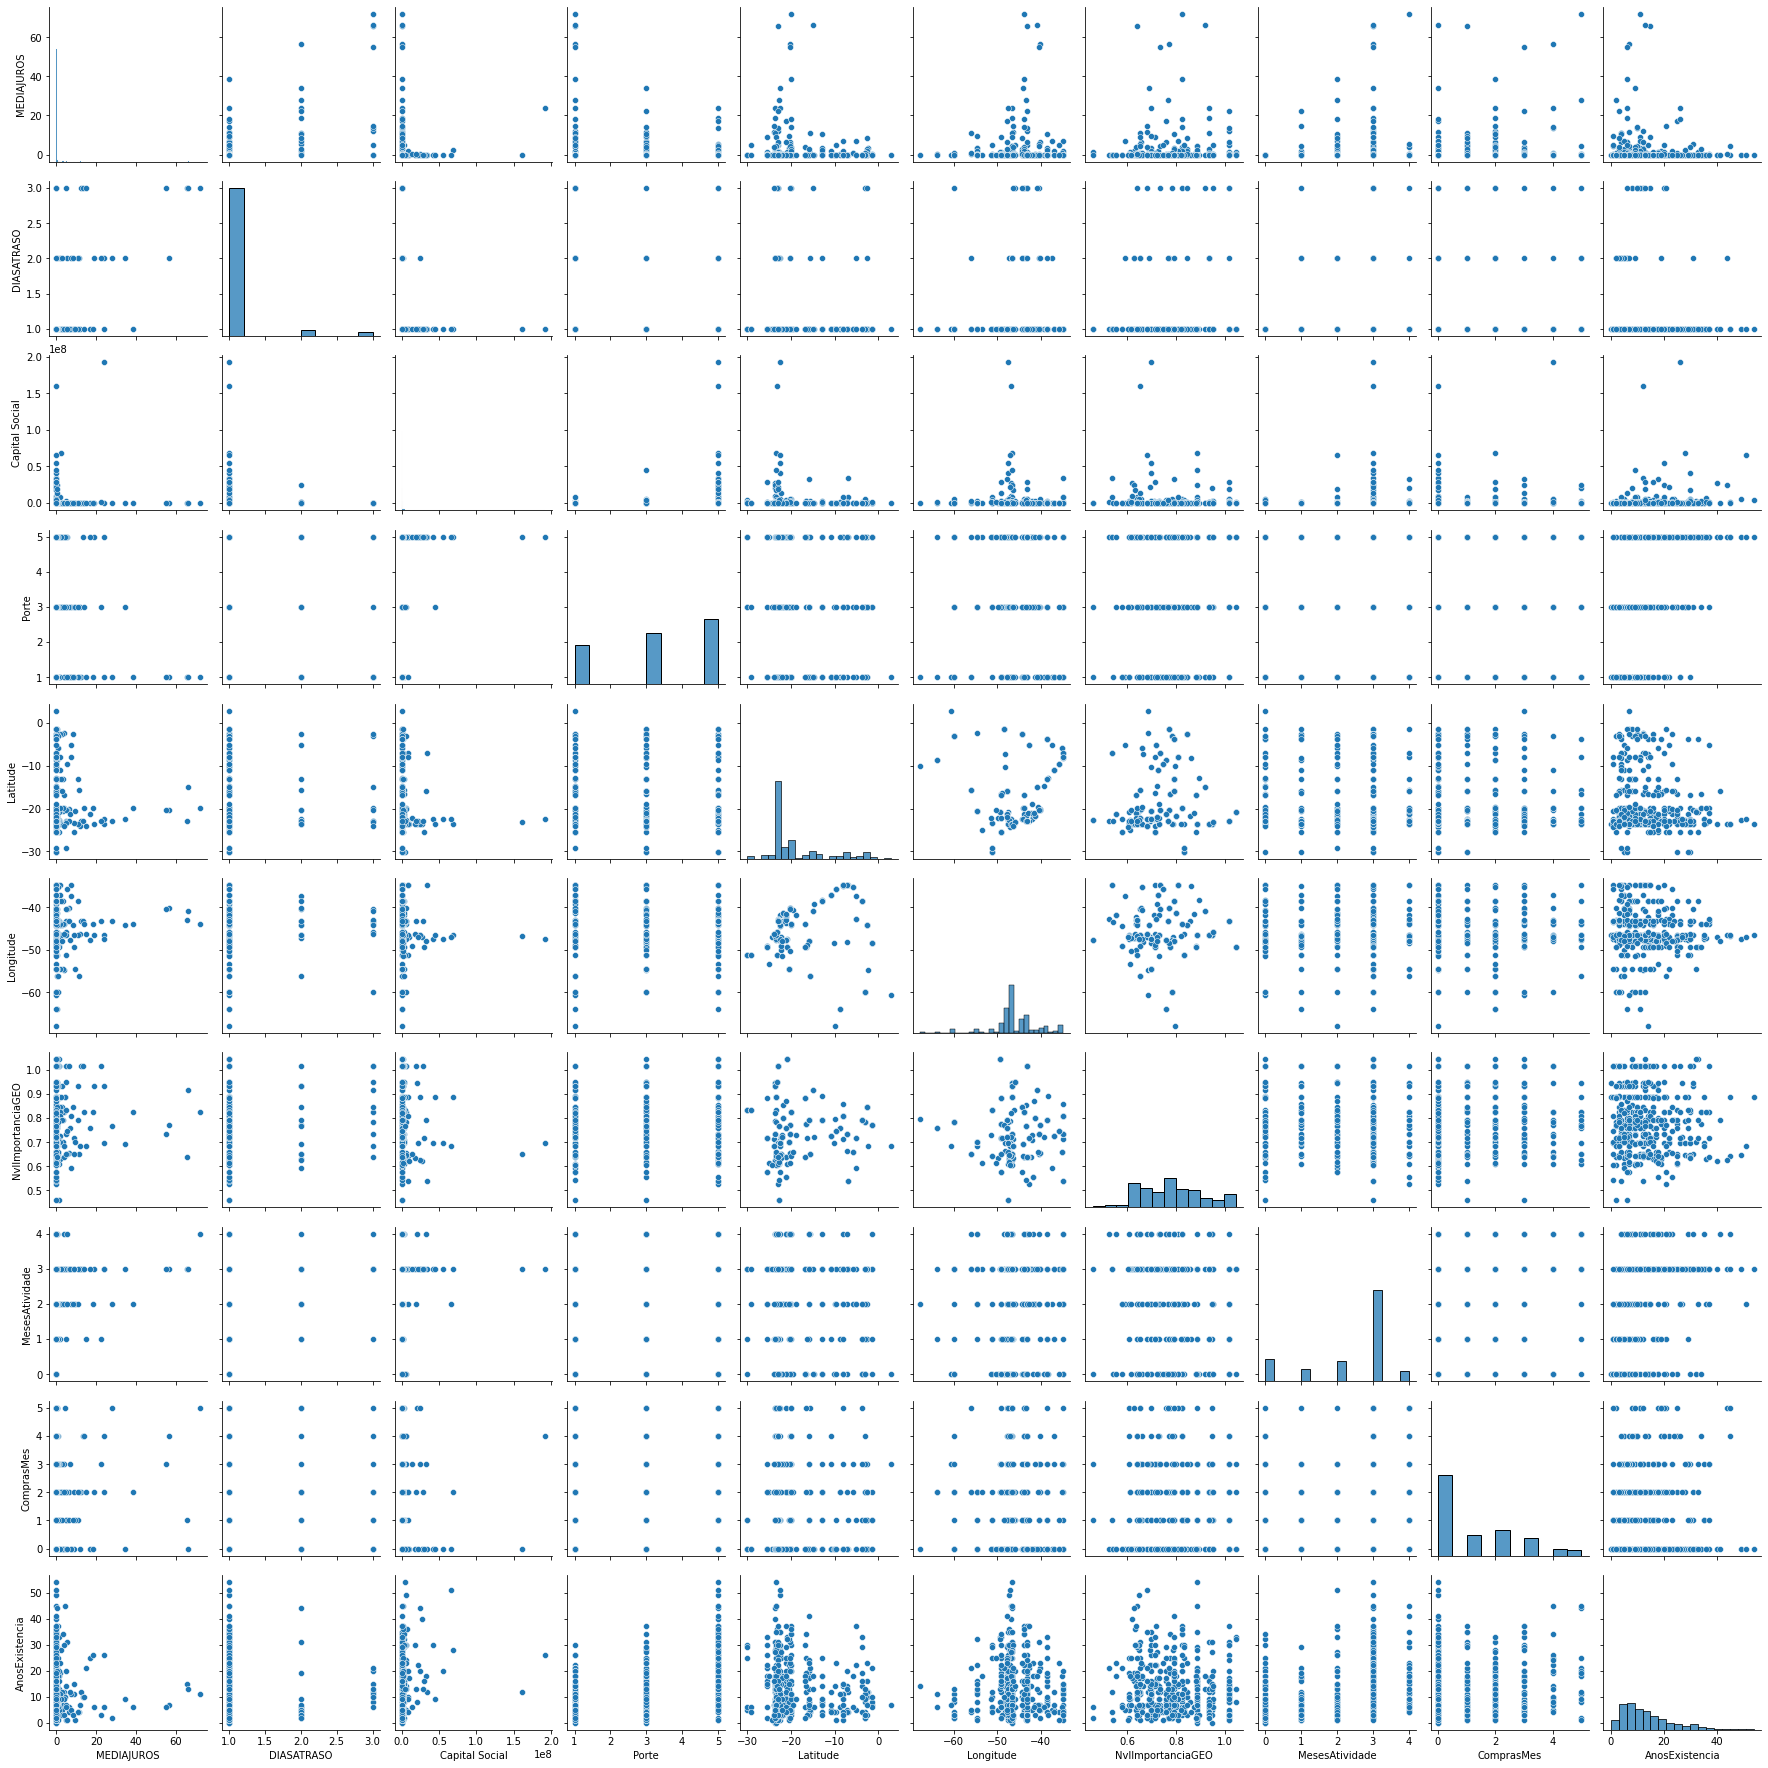

In [63]:
sns.pairplot(df[cols_originais])

In [64]:
df['MEDIAJUROS'].value_counts()

0.000     313
0.377       1
0.797       1
66.226      1
1.256       1
8.926       1
6.540       1
2.374       1
3.026       1
1.637       1
0.427       1
34.212      1
0.474       1
0.247       1
4.410       1
1.371       1
6.260       1
0.078       1
54.887      1
0.222       1
0.137       1
4.585       1
4.909       1
7.105       1
3.823       1
0.765       1
0.182       1
0.741       1
2.583       1
56.449      1
0.077       1
0.521       1
0.001       1
12.049      1
1.103       1
3.849       1
0.137       1
0.465       1
0.598       1
0.380       1
0.073       1
0.378       1
2.917       1
0.140       1
4.651       1
0.682       1
0.172       1
2.425       1
0.519       1
22.102      1
8.270       1
4.581       1
27.839      1
10.653      1
1.860       1
9.475       1
0.144       1
1.644       1
0.062       1
18.150      1
38.592      1
0.465       1
14.729      1
7.110       1
0.450       1
17.008      1
0.081       1
0.041       1
0.045       1
23.708      1
0.001       1
4.343 